In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_hub as hub 

In [3]:
# reading the data :
dataset = pd.read_csv('spam.csv' ,  encoding='latin-1')
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
dataset = dataset.dropna(axis=1)
dataset=dataset.rename(columns={'v1' : 'label' , 'v2' : 'text'})
# encode the target variable numerically and store into a new variable (label_enc) : 
dataset['label_enc'] = dataset['label'].map({'ham':0 , 'spam' : 1})
dataset.head()

,label,text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


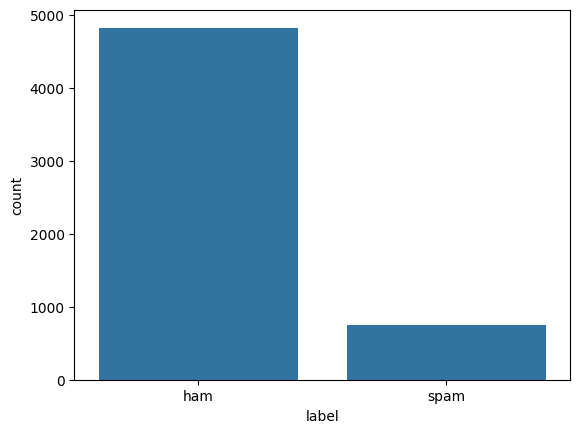

In [5]:
# examine the distribution of the spam and ham data : 
sns.countplot(x=dataset['label'])
plt.show()

In [23]:
av_num_words = round(sum([len(i.split()) for i in dataset['text']])/len(dataset['text']))
print(av_num_words) ## average number of words in all the sentences in the dataset 

15


In [7]:
# total number of unique words in the dataset : 
s = set()
for sent in dataset['text'] : 
    for word in sent.split() : 
        s.add(word)
total_number_words =len(s)
print(total_number_words) # unique words

15585


In [9]:
## preparing the data ==> splitting it for training and testing :
from sklearn.model_selection import train_test_split
X, y = np.asanyarray(dataset['text']), np.asanyarray(dataset['label_enc'])
new_dataset = pd.DataFrame({'text': X, 'label_enc': y})
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size=0.2 , random_state=42)

X_train.shape , y_train.shape , X_test.shape , y_test.shape 

((4457,), (4457,), (1115,), (1115,))

In [10]:
## Building the models :: the Baseline model : MultinomialNB()
from sklearn.feature_extraction.text import TfidfVectorizer ## Term Frequency - Inverse Document Frequency
''' 
TF-IDF : statistical measure used to evaluate the importance of a word in a document relative to a collection 
         of documents (corpus).

Term Frequency (TF): Measures how frequently a word occurs in a document. Higher frequencies indicate higher 
                     importance within the document.

Inverse Document Frequency (IDF): Measures how unique or rare a word is across the entire dataset. Words that
                                appear in many documents have a lower IDF, while words that appear in only a 
                                few documents are considered more important.
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report , accuracy_score 

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec , X_test_vec = tfidf_vec.transform(X_train) , tfidf_vec.transform(X_test)
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec , y_train)

MultinomialNB()

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



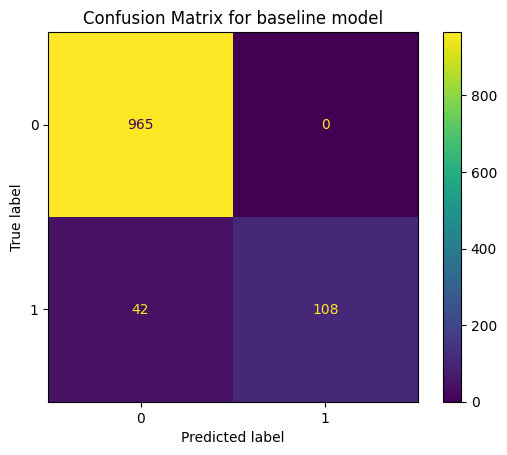

In [11]:
nb_accuracy = accuracy_score(y_test ,baseline_model.predict(X_test_vec))
print(nb_accuracy)

print(classification_report(y_test , baseline_model.predict(X_test_vec)))
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay 

cm = confusion_matrix(y_test , baseline_model.predict(X_test_vec))

disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=baseline_model.classes_)
disp.plot()
plt.title("Confusion Matrix for baseline model")
plt.show()

In [ ]:
### custom Text Vectorization and embedding layers : 
from tensorflow.keras.layers import TextVectorization
MAXTOKENS=total_number_words # maximum size of the vocabulary used (number of words in the dataset) 
OUTPUTLEN=av_num_words       # the length to which the sentences should be padded irrespective of the sentence length
text_vec = TextVectorization(max_tokens=MAXTOKENS , 
                             standardize='lower_and_strip_punctuation',
                             output_mode='int' ,
                             output_sequence_length=OUTPUTLEN)

text_vec.adapt(X_train) 

In [13]:
## creating an embedded layer : 
emb_layer = layers.Embedding(input_dim=MAXTOKENS, ## size of the vocabulary
                             output_dim=128,       ## dimension of the embedding layer (size of the vector in which the words will be embedded)
                             embeddings_initializer='uniform')

In [ ]:
## build and compile model_1 : 
input_layer = layers.Input(shape=(1,),dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = emb_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32 , activation='relu')(x)
output_layer = layers.Dense(1,activation='sigmoid')(x)
model_1=keras.Model(input_layer , output_layer)
model_1.compile(optimizer='adam' , loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5) , metrics=['accuracy'])
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,994,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,999,041 (7.63 MB)

 Trainable params: 1,999,041 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## training model_1 : 
M1_Train = model_1.fit(X_train , y_train , epochs=5, validation_data=(X_test,y_test) , validation_steps=int(0.2*len(X_test))) 

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8658 - loss: 0.6275 - val_accuracy: 0.9704 - val_loss: 0.5780
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9863 - loss: 0.5717 - val_accuracy: 0.9821 - val_loss: 0.5743
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9942 - loss: 0.5659 - val_accuracy: 0.9821 - val_loss: 0.5749
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9966 - loss: 0.5656 - val_accuracy: 0.9812 - val_loss: 0.5727
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9993 - loss: 0.5635 - val_accuracy: 0.9830 - val_loss: 0.5727


<Axes: >

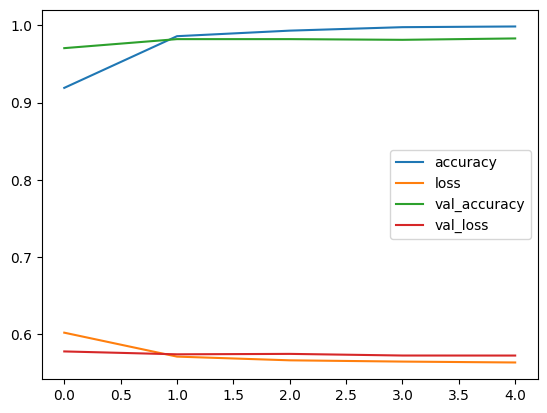

In [ ]:
pd.DataFrame(M1_Train.history).plot()

In [17]:
#### Helper Functions for compiling , fitting , and evaluating the model performance : 

from sklearn.metrics import precision_score , recall_score , f1_score 

def compile_model(model) : 
    '''
    Compile the model with Adam optimizer 
    
    '''
    model.compile(optimizer=keras.optimizers.Adam() ,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy']) 

def evaluate_model(model,X,y): 
    '''evaluate the model and return accuracy , precision and recall'''
    y_preds=np.round(model.predict(X))
    accuracy=accuracy_score(y,y_preds)
    f1=f1_score(y,y_preds)
    precision = precision_score(y,y_preds)
    recall=recall_score(y, y_preds)
    
    model_result_dict = {'accuracy' :  accuracy , 
                         'precision' : precision ,
                         'f1-score' : f1,
                         'recall': recall}
    return model_result_dict
def fit_model(model , epochs , X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test) : 
    '''fit the model with the given epochs , train test data'''
    if X_test is not None and y_test is not None :
        history = model.fit(X_train , y_train , epochs=epochs , validation_data=(X_test,y_test))
    else :
        history = model.fit(X_train, y_train ,epochs=epochs)
    return history
    

In [ ]:
# Model 2 : bidirectional LSTM Long-Short term memory
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer) 
embedding_layer_model = emb_layer(vec_layer)
bi_lstm =  layers.Bidirectional(layers.LSTM(64 , activation='tanh' , return_sequences=True ))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout= layers.Dropout(.1)(flatten)
x = layers.Dense(32 ,activation='relu' )(dropout)
output_layer = layers.Dense(1,activation='sigmoid')(x)
model_2 = keras.Model(input_layer , output_layer)
compile_model(model_2 )
M2_train = fit_model(model_2, epochs=5 , X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9587 - loss: 0.1592 - val_accuracy: 0.9794 - val_loss: 0.0711
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9776 - val_loss: 0.1136
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9830 - val_loss: 0.1098
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 5.3868e-05 - val_accuracy: 0.9830 - val_loss: 0.1209
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 1.0000 - loss: 2.9318e-05 - val_accuracy: 0.9830 - val_loss: 0.1273


<Axes: >

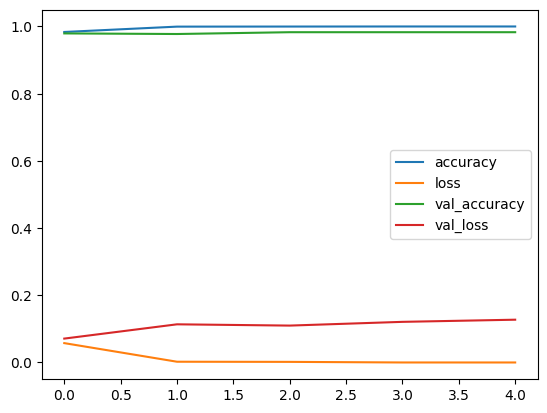

In [19]:
pd.DataFrame(M2_train.history).plot()

In [25]:
# Model 3 : Transfer Learning with USE (Universal Sentence Encoder ) Encoder : 
import tensorflow_hub as hub 
tf.config.optimizer.set_jit(False)
input_layer = keras.Input(shape=[] , dtype=tf.string)
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                        trainable=False, 
                        input_shape=[], 
                        dtype=tf.string, 
                        name='USE')

x = layers.Lambda(lambda x:use_layer(x) , output_shape=(512,))(input_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(1,activation='sigmoid')(x)

model_3 = keras.Model(input_layer , output_layer)
compile_model(model_3)

M3_train = fit_model(model_3 , epochs=5 , X_train=X_train ,y_train=y_train ,X_test=X_test , y_test=y_test) 

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8250 - loss: 0.4796 - val_accuracy: 0.9695 - val_loss: 0.1191
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9770 - loss: 0.0993 - val_accuracy: 0.9767 - val_loss: 0.0722
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9833 - loss: 0.0607 - val_accuracy: 0.9803 - val_loss: 0.0600
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9862 - loss: 0.0539 - val_accuracy: 0.9830 - val_loss: 0.0534
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9903 - loss: 0.0422 - val_accuracy: 0.9839 - val_loss: 0.0520


In [26]:
##### Comparing the models : 

baseline_model_results = evaluate_model(baseline_model , X_test_vec , y_test)
model_1_results = evaluate_model(model_1 , X_test , y_test)
model_2_results = evaluate_model(model_2 , X_test , y_test)
model_3_results = evaluate_model(model_3 , X_test , y_test)

Result = pd.DataFrame({'MultinominalNB Model' : baseline_model_results,
                      'Custom VEC Embedding Model' : model_1_results,
                      'Bidirectional LSTM Model' : model_2_results,
                      'USE-Transfer Learning Model' : model_3_results}).transpose()
Result

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,accuracy,precision,f1-score,recall
MultinominalNB Model,0.962332,1.000000,0.837209,0.720000
Custom VEC Embedding Model,0.981166,0.992366,0.925267,0.866667
Bidirectional LSTM Model,0.982960,0.978102,0.933798,0.893333
USE-Transfer Learning Model,0.983857,0.978261,0.937500,0.900000
